In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import scipy.constants as con

# Get the data using the astropy ascii
data = ascii.read("SED.dat",data_start=4)
lam=data[0][:]     # Wavelength column
logf=data[1][:]    # log10(flux)
errlogf=data[2][:] # Error on log10(flux)

# Shape parameters for priors
Teffmin = 10.0
Teffmax = 1000.0
logfacmin = -100.0
logfacmax = 0.0
thetashape=np.array([[Teffmin,Teffmax],[logfacmin,logfacmax]])

In [2]:
# Set a definition for the model
def model(microns,Teff,logfactor):
  wavelength = microns*1.0e-6
  flux=np.empty([len(wavelength)])
  logflux=np.empty([len(wavelength)])
  for i in range(len(wavelength)):
    # Flux is just the Planck function
    flux[i] = ( (2.0*con.h*con.c**2)/(wavelength[i]**5) )/( np.exp( (con.h*con.c)/(con.k*Teff*wavelength[i]) ) - 1.0 )
    # So logflux (which is what we want) is just the log of this
    logflux[i] = logfactor + np.log10(flux[i])
  return logflux

In [3]:
# Set a definition for the loglikelihood, assuming normally distributed data
def log_like(lam,logf,errlogf,theta):
    residuals = logf - model(lam,theta[0],theta[1])
    loglike=0.0
    for i in range(len(lam)):
        loglike = loglike - np.log(errlogf[i]) - 0.5*(residuals[i]/errlogf[i])**2
    loglike = loglike - 0.5*len(lam)*np.log(2.0*np.pi)
    return loglike

In [4]:
# Set a definition for the logpriors
def log_prior(theta,thetashape):
    
    logpriors=np.empty([len(theta)])
    #logprior=0.0
    
    # Prior for theta[0]: Teff~logU[Teffmin,Teffmax]
    Teff = theta[0]
    Teffmin = thetashape[0][0]
    Teffmax = thetashape[0][1]
    if Teffmin < Teff < Teffmax:
        logpriors[0] = ( 1.0/(np.log(Teffmax) - np.log(Teffmin)) )/Teff
    else:
        logpriors[0] = -1.0e99 # -infinity
    
    # Prior for theta[1]: logfac~U[logfacmin,logfacmax]
    logfac = theta[1]
    logfacmin = thetashape[1][0]
    logfacmax = thetashape[1][1]
    if logfacmin < logfac < logfacmax:
        logpriors[1] = 1.0/(logfacmax - logfacmin)
    else:
        logpriors[1] = -1.0e99 # -infinity
        
    #logprior = np.sum(logpriors)
    return np.sum(logpriors)

In [21]:
# Initialize the MCMC from a random point drawn from the prior
Teffinitial = np.exp( np.random.uniform(np.log(thetashape[0][0]),np.log(thetashape[0][1])) )
logfacinitial=np.random.uniform(thetashape[1][0],thetashape[1][1])
thetachain=np.array([[Teffinitial,logfacinitial]])
# Calculate the associated modified loglike
loglikechain=np.empty([1])
loglikechain[0]=log_prior(thetachain[0],thetashape) + log_like(lam,logf,errlogf,thetachain[0])

In [6]:
# Define the proposal jump size
Teffjump=5
logfacjump=0.1
thetajump=np.array([Teffjump,logfacjump])

# Starting walking
j=0
jmax=10000
while True:
    
    # Generate a proposal (or jump)
    thetatrial=np.array([np.random.normal(thetachain[j][0],thetajump[0]),np.random.normal(thetachain[j][1],thetajump[1])])
    logliketrial=log_prior(thetatrial,thetashape) + log_like(lam,logf,errlogf,thetatrial)
    deltaloglike=logliketrial-loglikechain[j]

    # Compute Metropolis Rule
    if deltaloglike > 0:
        probjump = 1.0
    else:
        probjump = np.exp(deltaloglike)

    if probjump>np.random.uniform(0,1):
        # Accept the jump
        j = j + 1
        loglikechain = np.append(loglikechain,logliketrial)
        thetachain = np.vstack((thetachain,thetatrial))
        
    if j==jmax:
        break

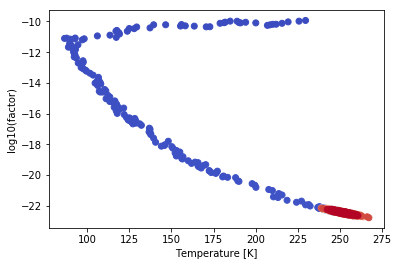

In [7]:
%matplotlib inline

jlist=np.arange(len(thetachain))
plt.scatter(thetachain[:,0], thetachain[:,1], c=jlist, cmap='coolwarm')
plt.xlabel('Temperature [K]')
plt.ylabel('log10(factor)')
plt.show()

In [8]:
np.max(loglikechain)

8.644224243977872

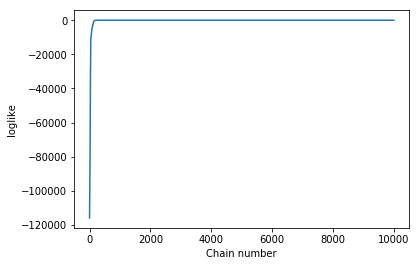

In [9]:
%matplotlib inline

plt.plot(loglikechain)
plt.xlabel('Chain number')
plt.ylabel('loglike')
plt.show()

In [10]:
loglikeburn=np.median(loglikechain)
j=-1
while True:
    j=j+1
    if loglikechain[j] > loglikeburn:
        break
burnj=j
print( 'Burn point = ',burnj)

Burn point =  180


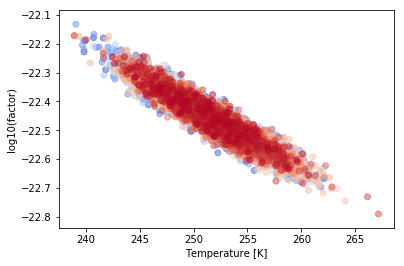

Temperature [K] =  251.7 - 3.5 + 3.6
log10(factor) =  -22.462 - 0.08 + 0.082


In [11]:
%matplotlib inline

jlist=np.arange(len(thetachain))
plt.scatter(thetachain[burnj:,0], thetachain[burnj:,1], c=jlist[burnj:], cmap='coolwarm',alpha=0.5)
plt.xlabel('Temperature [K]')
plt.ylabel('log10(factor)')
plt.show()
print( 'Temperature [K] = ',np.round(np.median(thetachain[burnj:,0]),1),'-',np.round(np.median(thetachain[burnj:,0])-np.percentile(thetachain[burnj:,0],15.9),1),'+',np.round(np.percentile(thetachain[burnj:,0],84.1)-np.median(thetachain[burnj:,0]),1))
print( 'log10(factor) = ',np.round(np.median(thetachain[burnj:,1]),3),'-',np.round(np.median(thetachain[burnj:,1])-np.percentile(thetachain[burnj:,1],15.9),3),'+',np.round(np.percentile(thetachain[burnj:,1],84.1)-np.median(thetachain[burnj:,1]),3))

In [12]:
ascii.write(thetachain[burnj:,:], "chains.dat")

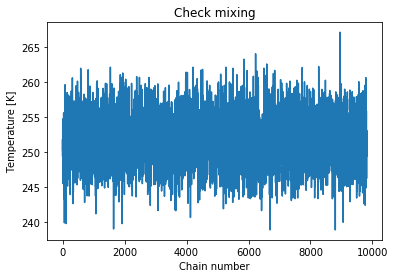

In [13]:
%matplotlib inline

plt.plot(thetachain[burnj:,0])
plt.title('Check mixing')
plt.xlabel('Chain number')
plt.ylabel('Temperature [K]')
plt.show()

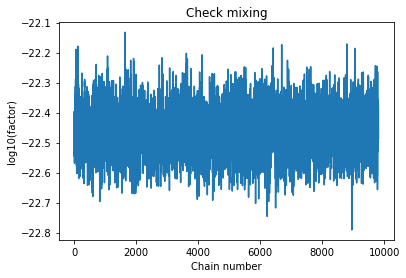

In [14]:
%matplotlib inline

plt.plot(thetachain[burnj:,1])
plt.title('Check mixing')
plt.xlabel('Chain number')
plt.ylabel('log10(factor)')
plt.show()

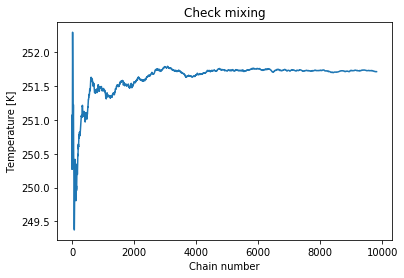

In [15]:
%matplotlib inline

temp=np.empty([len(thetachain)-burnj])
temp[0]=thetachain[burnj,0]
for i in range(burnj+1,len(thetachain)):
    temp[i-burnj]=np.mean(thetachain[burnj:i,0])
plt.plot(temp)
plt.title('Check mixing')
plt.xlabel('Chain number')
plt.ylabel('Temperature [K]')
plt.show()

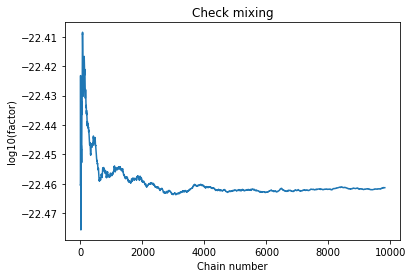

In [16]:
%matplotlib inline

temp=np.empty([len(thetachain)-burnj])
temp[0]=thetachain[burnj,1]
for i in range(burnj+1,len(thetachain)):
    temp[i-burnj]=np.mean(thetachain[burnj:i,1])
plt.plot(temp)
plt.title('Check mixing')
plt.xlabel('Chain number')
plt.ylabel('log10(factor)')
plt.show()